# __[ LG Energy Solution ] <br><br>Anomaly Detection Part1: Data Preprocessing__

# <br>__1. Data: NASA Bearing Dataset__

- 데이터 description <br>
    - NASA Bearing Dataset은 NSF I/UCR Center의 Intelligent Maintenance System의 4개의 bearing에서 고장이 발생할 때까지 10분 단위로 수집된 센서 데이터이다. 본 데이터셋은 특정 구간에서 기록된 1-second vibration signal snapshots을 나타내는 여러 개의 파일로 구성되어 있다. 각 파일은 20 kHz 단위로 샘플링 된 20,480개의 data point를 포함하고 있으며, 각 파일의 이름은 데이터가 수집된 시간을 의미한다. 해당 데이터셋은 크게 3개의 데이터를 포함하고 있으며, 본 실습에서 사용하는 데이터는 bearing 1에서 outer race failure가 발생할 때까지 수집된 센서 데이터이다. <br><br>
- 변수
    -  센서 데이터: Bearing1, Bearing2, Bearing3, Bearing4
<br><br>
- 출처: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

<img src="https://i.imgur.com/dfFzn3H.jpg" width="600">

In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/hj-choi-95/Anomaly_Detection_Part1.git

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Step1. 데이터 병합

In [2]:
# 데이터 로드 및 병합
# data_root_dir에 있는 txt 파일 각각에 대하여 순차적으로 파일을 불러온 후, 변수별 절댓값 평균을 축적하여 데이터를 구축
data_root_dir = '/content/Anomaly_Detection_Part1/data/raw_data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_root_dir):
    # 데이터 불러오기
    data = pd.read_csv(os.path.join(data_root_dir, filename), sep='\t', header=None)
    
    # 변수별 절댓값 평균 계산
    data_mean_abs = np.array(data.abs().mean())
    data_mean_abs = pd.DataFrame(data_mean_abs.reshape(1, 4))
    data_mean_abs.index = [filename]
    
    # 데이터 축적 -> 한 개의 txt 파일에 대하여 4개의 변수 값을 도출
    merged_data = merged_data.append(data_mean_abs)

In [3]:
# merged data index 및 column 설정
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118


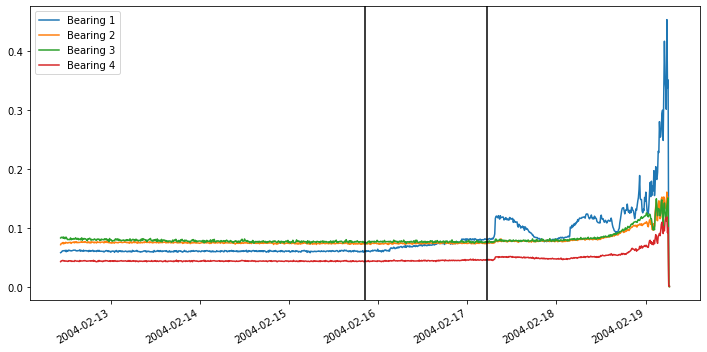

In [4]:
# 전체 기간의 데이터 분포 확인
merged_data.plot(figsize = (12, 6))
plt.axvline(merged_data.index[int(len(merged_data) * 0.5)], c='black')
plt.axvline(merged_data.index[int(len(merged_data) * 0.7)], c='black')

In [5]:
# normal/abnormal labeling
# 분류 모델을 학습하기 위해 변수의 값이 크게 변화하는 후반부 30%를 고장으로 labeling
num_normal = int(len(merged_data) * 0.7)
num_abnormal = len(merged_data) - num_normal

In [6]:
merged_data['anomaly'] = [0] * num_normal + [1] * num_abnormal
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065,0
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540,0
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442,0
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081,0
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118,0


### Step2. 데이터 Split

In [7]:
# train 및 test 데이터 분리 (시간에 대한 iid 가정)
num_train = int(len(merged_data) * 0.5)
num_test = len(merged_data) - num_train

In [8]:
merged_data['data_type'] = ['train'] * num_train + ['test'] * num_test
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065,0,train
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540,0,train
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442,0,train
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081,0,train
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118,0,train


In [9]:
# train data의 label 분포
merged_data[merged_data['data_type'] == 'train'].groupby('anomaly').size()

anomaly
0    492
dtype: int64

In [10]:
# test data의 label 분포
merged_data[merged_data['data_type'] == 'test'].groupby('anomaly').size()

anomaly
0    196
1    296
dtype: int64

In [11]:
# 데이터 저장
merged_data.to_csv('/content/Anomaly_Detection_Part1/data/nasa_bearing_dataset.csv')

---